In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('../input/health-insurance-lead-prediction/train.csv')
data

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


In [3]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop ID column
    df = df.drop('ID', axis=1)
    
    # Drop columns with too many missing values
    df = df.drop(['Holding_Policy_Duration', 'Holding_Policy_Type'], axis=1)
    
    # Drop high-cardinality columns
    df = df.drop('Region_Code', axis=1)
    
    # Fill remaining missing values
    df['Health Indicator'] = df['Health Indicator'].fillna(df['Health Indicator'].mode()[0])
    
    # Binary encoding
    df['Accomodation_Type'] = df['Accomodation_Type'].replace({'Rented': 0, 'Owned': 1})
    df['Reco_Insurance_Type'] = df['Reco_Insurance_Type'].replace({'Individual': 0, 'Joint': 1})
    df['Is_Spouse'] = df['Is_Spouse'].replace({'No': 0, 'Yes': 1})
    
    # One-hot encoding
    for column in ['City_Code', 'Health Indicator', 'Reco_Policy_Cat']:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    
    # Split df into X and y
    y = df['Response']
    X = df.drop('Response', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [5]:
model = LogisticRegression(
    class_weight={
        0: 1.0,
        1: 2.5
    }
)
model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0, 1: 2.5})

Test Accuracy: 66.56%


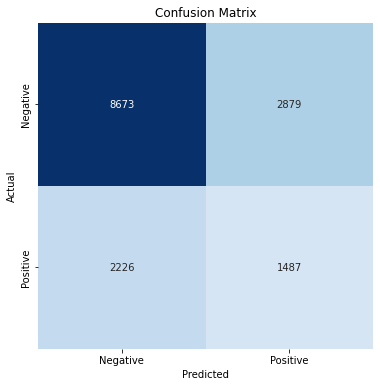

Classification Report:
----------------------
               precision    recall  f1-score   support

    Negative       0.80      0.75      0.77     11552
    Positive       0.34      0.40      0.37      3713

    accuracy                           0.67     15265
   macro avg       0.57      0.58      0.57     15265
weighted avg       0.69      0.67      0.67     15265



In [6]:
acc = model.score(X_test, y_test)
y_pred = model.predict(X_test)

print("Test Accuracy: {:.2f}%".format(acc * 100))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["Negative", "Positive"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)